<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
TEST_SIZE = 0.1
RANDOM_STATE = 12345

In [2]:
import os
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit
)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from time import time
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

In [3]:
import warnings
# настройки
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = (10,8) 

## Подготовка

In [5]:
def upload(pth):
    if os.path.exists(pth):
        market_file = pd.read_csv(pth)
        return pd.read_csv(pth, parse_dates =[0],index_col= 0)
    else:
        print('Something is wrong')

In [6]:
pth = '/datasets/taxi.csv'
df = upload(pth)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
df1 = df.resample("1H").sum()

## Анализ

In [9]:
def make_features(data):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, 8):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(1).mean()
    data.dropna(inplace=True)
    return data

In [10]:
df1.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


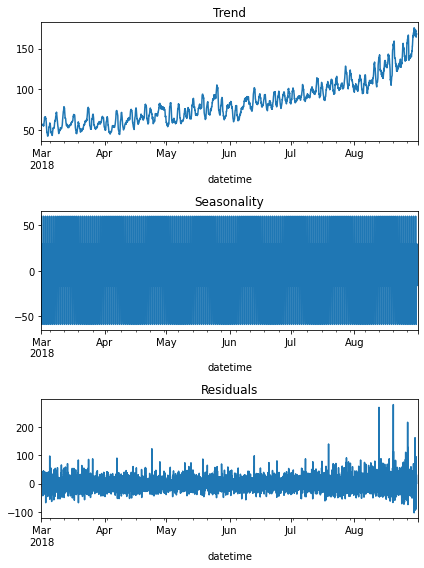

In [11]:
decomposed = seasonal_decompose(df1)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

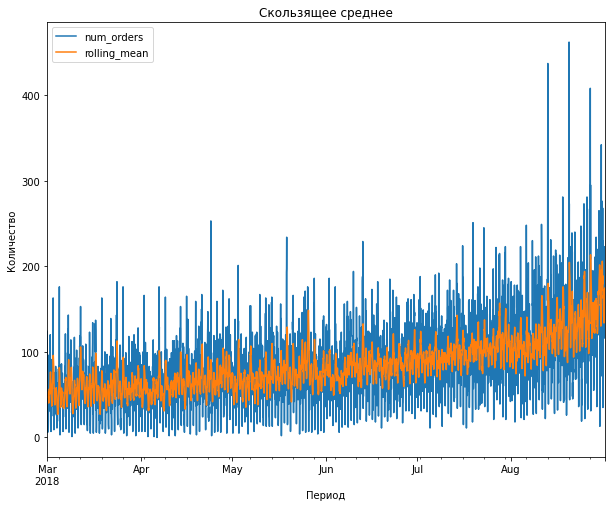

In [12]:
df1['rolling_mean'] = df1.rolling(10).mean() 
df1.plot()
plt.title('Cкользящее среднее')
plt.xlabel('Период')
plt.ylabel('Количество')
plt.show()

In [13]:
df_t = df.resample("1D").sum()

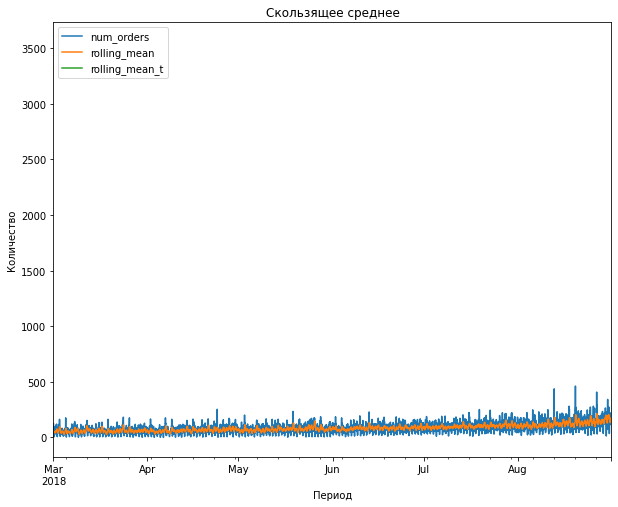

In [14]:
df1['rolling_mean_t'] = df_t.rolling(10).mean() 
df1.plot()
plt.title('Cкользящее среднее')
plt.xlabel('Период')
plt.ylabel('Количество')
plt.show()

In [15]:
df2 = df1.copy()
df2 = make_features(df2)

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175 entries, 2018-03-10 to 2018-08-31
Freq: 24H
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      175 non-null    int64  
 1   rolling_mean    175 non-null    float64
 2   rolling_mean_t  175 non-null    float64
 3   day             175 non-null    int64  
 4   hour            175 non-null    int64  
 5   dayofweek       175 non-null    int64  
 6   lag_1           175 non-null    float64
 7   lag_2           175 non-null    float64
 8   lag_3           175 non-null    float64
 9   lag_4           175 non-null    float64
 10  lag_5           175 non-null    float64
 11  lag_6           175 non-null    float64
 12  lag_7           175 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 19.1 KB


In [17]:
df2.head(5)

,num_orders,rolling_mean,rolling_mean_t,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,
2018-03-10,117,49.0,1311.2,10,0,5,49.0,82.0,70.0,60.0,48.0,39.0,66.0
2018-03-11,81,73.0,1334.8,11,0,6,73.0,80.0,62.0,54.0,33.0,102.0,60.0
2018-03-12,102,118.0,1346.4,12,0,0,118.0,89.0,119.0,99.0,99.0,107.0,78.0
2018-03-13,91,57.0,1354.3,13,0,1,57.0,67.0,81.0,46.0,45.0,107.0,94.0
2018-03-14,84,75.0,1368.0,14,0,2,75.0,62.0,77.0,91.0,40.0,109.0,35.0


In [18]:
df2.describe()

,num_orders,rolling_mean,rolling_mean_t,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
count,175.000000,175.000000,175.000000,175.000000,175.0,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,146.645714,111.337143,1999.926857,16.394286,0.0,3.000000,111.337143,98.028571,95.862857,81.605714,78.325714,68.160000,93.937143
std,48.806328,37.827733,547.629114,8.727613,0.0,2.005739,37.827733,34.580978,32.189517,25.491467,25.632060,26.928761,45.585231
min,52.000000,46.000000,1311.200000,1.000000,0.0,0.000000,46.000000,45.000000,32.000000,37.000000,33.000000,25.000000,23.000000
25%,107.000000,84.500000,1572.700000,9.000000,0.0,1.000000,84.500000,73.500000,75.500000,62.000000,62.000000,48.000000,60.000000
50%,145.000000,107.000000,1917.600000,17.000000,0.0,3.000000,107.000000,90.000000,93.000000,78.000000,77.000000,62.000000,88.000000
75%,172.000000,127.000000,2362.400000,24.000000,0.0,5.000000,127.000000,111.000000,113.000000,95.500000,92.500000,81.500000,120.000000
max,281.000000,265.000000,3555.700000,31.000000,0.0,6.000000,265.000000,242.000000,214.000000,191.000000,169.000000,177.000000,342.000000


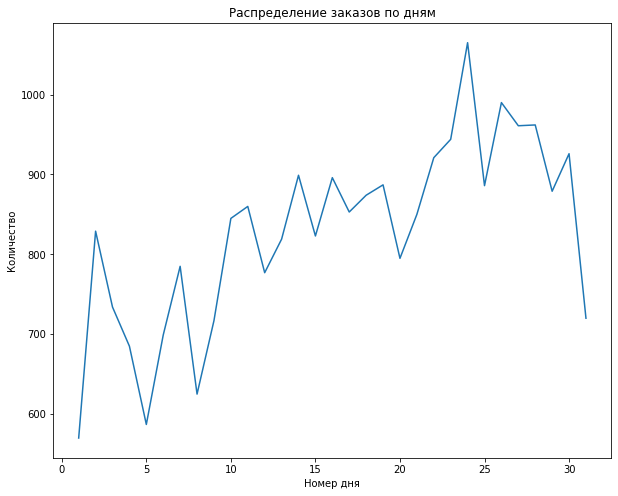

In [19]:
df2.groupby('day')['num_orders'].sum().plot()
plt.title('Распределение заказов по дням')
plt.xlabel('Номер дня')
plt.ylabel('Количество')
plt.show()

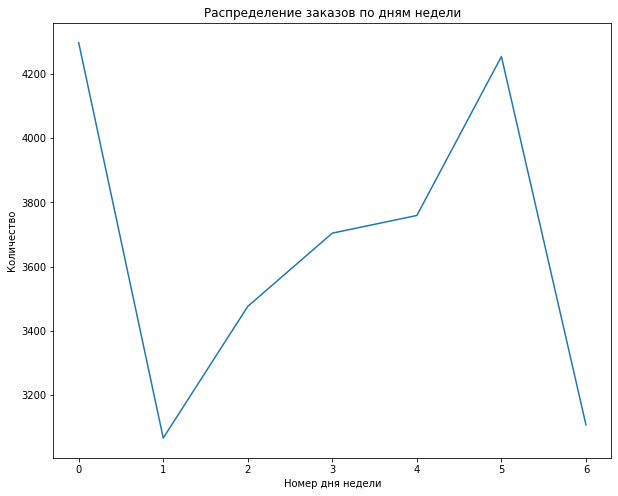

In [20]:
df2.groupby('dayofweek')['num_orders'].sum().plot()
plt.title('Распределение заказов по дням недели')
plt.xlabel('Номер дня недели')
plt.ylabel('Количество')
plt.show()

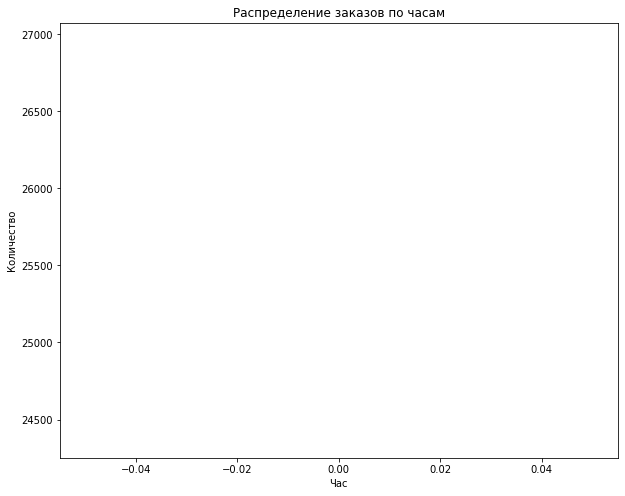

In [21]:
df2.groupby('hour')['num_orders'].sum().plot()
plt.title('Распределение заказов по часам')
plt.xlabel('Час')
plt.ylabel('Количество')
plt.show()

**Вывод:** по графикам видно, что количество заказов выше: во второй половине месяца, в середине недели (среда-пятница), во второй половине дня до полуночи.

Разложили временной ряд на три составляющие: тренд, сезонность и остаток. Чтобы снизить колебания, применили скользящее среднее.

Количество заказов распределено равномерно, есть увеличение с августа.

## Обучение

In [22]:
features = df2.drop(['num_orders'], axis=1)
target = df2['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False
)

In [23]:
X_train.shape

(157, 12)

In [24]:
X_test.shape

(18, 12)

In [25]:
X_train.dropna(inplace=True)

In [26]:
X_test.dropna(inplace=True)

In [27]:
cat_cols = ['day', 'dayofweek', 'hour'] 
num_cols = ['rolling_mean', 'rolling_mean_t', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'] #, 'lag_8', 'lag_9', 'lag_10', 'lag_11'

In [28]:
oe_processor = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

data_preprocessor = ColumnTransformer([
    ('cat_oe', oe_processor, cat_cols),
    ('num', StandardScaler(), num_cols)], remainder='passthrough')

pipe_final = Pipeline(
    # Финальный пайплайн
    [('preprocessor', data_preprocessor), ('model', lgb.LGBMRegressor())]
)

In [29]:
# Параметры LGBM регрессии
lgbm_params = {}

lgbm_params['model__n_estimators'] = [100, 200]
lgbm_params['model__max_depth'] = [2, 4, 6] 
#lgbm_params['model__learning_rate'] = [0.1]
lgbm_params['model'] = [
    lgb.LGBMRegressor()  #random_state=RANDOM_STATE, metric='rmse'
]

# Параметры дерева решений

tree_params = {}

tree_params['model__max_depth'] = [1, 2, 5]
tree_params['model__min_samples_split'] = [10, 14, 15]
tree_params['model'] = [DecisionTreeRegressor(random_state=RANDOM_STATE)] 

# Параметры CatBoostRegressor

cboost_params = {}

cboost_params['model__max_depth'] = [5, 10]
cboost_params['model__learning_rate'] = [0.1, 0.2, 1]
cboost_params['model'] = [CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=False)] 

params = [tree_params, lgbm_params, cboost_params]

In [30]:
grid_reg = GridSearchCV(pipe_final, params, cv = TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error', n_jobs=-1) 

In [31]:
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_oe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['day',
                              

In [32]:
# Сохраним лучшую модель в отдельную переменную
best_model = grid_reg.best_estimator_.steps[1][1]

In [33]:
# Узнаем её RMSE
grid_reg.best_score_ * (-1)

35.800244654291134

In [34]:
results= pd.DataFrame(grid_reg.cv_results_)

# Поиск индексов строк с максимальными значениями метрик
results['model_name'] = results['param_model'].apply(lambda x: str(x).split('(')[0])
max_index = results.groupby('model_name')['mean_test_score'].idxmax()

# Извлечение результатов лучших моделей
best_models = results.loc[max_index]

# Преобразование отрицательных значений метрик в положительные
if 'mean_test_score' in best_models:
    best_models['mean_test_score'] *= -1

# Сортировка результатов по значению метрики
sorted_results = best_models.sort_values(['mean_test_score'], ascending=True).reset_index(drop=True)

# Вывод результатов
sorted_results[['model_name','mean_test_score', 'mean_fit_time', 'mean_score_time']]

,model_name,mean_test_score,mean_fit_time,mean_score_time
0,<catboost.core.CatBoostRegressor object at 0x7...,35.800245,1.229605,0.006644
1,LGBMRegressor,35.824674,0.115913,0.022328
2,DecisionTreeRegressor,37.423401,0.010217,0.005065


Обучили три модели. Лучшая метрика RSME у CatBoostRegressor.

In [35]:
X_train_prepared = data_preprocessor.fit_transform(X_train)

## Тестирование

In [36]:
y_test_pred = best_model.predict(X_test)

In [37]:
mean_squared_error(y_test, y_test_pred) ** 0.5

42.49074455448011

Лучшая модель, соответствующая требованию "не больше 48", является LGBMRegressor с метрикой RSME на тестовой выборке - 42, 49.